In [1]:

'''# =======================================
# 0) Imports
import tempfile
import subprocess
# =======================================
import os
import torch
import pickle
import pandas as pd
import numpy as np
from glob import glob
import cv2
import torchaudio
from torchvision import transforms
from tqdm import tqdm
import ffmpeg

# =======================================
# 1) Load Models
# =======================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------- VIDEO MODEL --------
import timm
import torch.nn as nn

class EfficientNetVideoModel(nn.Module):
    def __init__(self, backbone_name="efficientnet_b0", pretrained=False, num_classes=2):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=0)
        in_features = self.backbone.num_features
        self.dropout = nn.Dropout(0.15)
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        features = self.backbone(x)
        features = features.view(B, T, -1).mean(dim=1)
        features = self.dropout(features)
        logits = self.classifier(features)
        return logits

VIDEO_MODEL_PATH = "/kaggle/input/video-model-efficentnet-b0/pytorch/default/1/video_efficientnet_b0.pth"
video_model = EfficientNetVideoModel(pretrained=False, num_classes=2)
video_model.load_state_dict(torch.load(VIDEO_MODEL_PATH, map_location=device))
video_model.eval().to(device)

# -------- METADATA MODEL --------
META_PIPELINE_PATH = "/kaggle/input/meta-data-model-randomforest/scikitlearn/default/1/metadata_model_pipeline.pkl"
with open(META_PIPELINE_PATH, "rb") as f:
    meta_pipeline = pickle.load(f)

# -------- AUDIO MODEL --------
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
AUDIO_MODEL_DIR = "/kaggle/input/audio-model-wave2vec/pytorch/default/1"
audio_model = Wav2Vec2ForSequenceClassification.from_pretrained(AUDIO_MODEL_DIR).to(device).eval()
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(AUDIO_MODEL_DIR)

# =======================================
# 2) Lip Sync Model (placeholder)
# =======================================
class DummyLipSyncModel:
    def predict(self, frames): return np.random.rand()

lip_sync_model = DummyLipSyncModel()
def get_lip_sync_score(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret: break
        frames.append(cv2.resize(frame, (96, 96)))
    cap.release()
    return float(lip_sync_model.predict(np.array(frames))) if frames else 0.0

# =======================================
# 3) Video Preprocessing
# =======================================
video_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

def extract_video_frames(video_path, num_frames=16):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, total-1, num_frames).astype(int)
    frames = []
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ok, frame = cap.read()
        if not ok: continue
        frames.append(video_transform(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
    cap.release()
    return torch.stack(frames).unsqueeze(0).to(device) if frames else None

# =======================================
# 4) Audio Probability
# =======================================
# Fast audio extraction using ffmpeg
def extract_audio_from_video(video_path, target_sr=16000, max_duration=None):
    """
    Extract audio from video, convert to mono, resample to target_sr, optionally limit duration.
    Returns: waveform (numpy array), sample rate
    """
    with tempfile.NamedTemporaryFile(suffix=".wav") as tmpfile:
        tmp_wav_path = tmpfile.name
        cmd = ["ffmpeg", "-y", "-i", video_path, "-ac", "1", "-ar", str(target_sr)]
        if max_duration:
            cmd += ["-t", str(max_duration)]
        cmd += [tmp_wav_path]
        subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        waveform, sr = torchaudio.load(tmp_wav_path)
        return waveform.squeeze(0).numpy(), sr


# New audio probability function
def audio_probability(video_path, max_duration=10):
    """
    Returns Wav2Vec2 probability for 'fake' class.
    Only uses first max_duration seconds for speed.
    """
    try:
        audio, sr = extract_audio_from_video(video_path, max_duration=max_duration)
        # Convert to torch tensor
        audio_tensor = torch.tensor(audio, dtype=torch.float32)
        # Feature extraction
        inputs = feature_extractor(audio_tensor, sampling_rate=sr, return_tensors="pt")
        # Forward pass
        with torch.no_grad():
            outputs = audio_model(**inputs.to(device))
            probs = torch.softmax(outputs.logits, dim=1)
            return float(probs[:, 1].item())
    except Exception as e:
        print(f"Audio processing error for {video_path}: {e}")
        return 0.0

# =======================================
# 5) Metadata Probability
# =======================================
def extract_metadata_features(video_path):
    try:
        probe = ffmpeg.probe(video_path)
        fmt = probe.get('format', {})
        streams = probe.get('streams', [])

        md = {"duration": float(fmt.get("duration",0)),
              "overall_bitrate": int(fmt.get("bit_rate",0)),
              "container": fmt.get("format_name",""),
              "v_codec":"", "v_width":0, "v_height":0, "v_fps":0, "v_bitrate":0,
              "a_codec":"", "a_bitrate":0}

        for s in streams:
            if s["codec_type"]=="video":
                md.update({"v_codec":s.get("codec_name",""), 
                           "v_width":int(s.get("width",0)),
                           "v_height":int(s.get("height",0)),
                           "v_fps":eval(s.get("r_frame_rate","0")),
                           "v_bitrate":int(s.get("bit_rate",0))})
            elif s["codec_type"]=="audio":
                md.update({"a_codec":s.get("codec_name",""), 
                           "a_bitrate":int(s.get("bit_rate",0))})

        eps = 1e-6
        md["bitrate_per_pixel"] = md["v_bitrate"]/(md["v_width"]*md["v_height"]+eps)
        md["quality_factor"] = md["v_bitrate"]/(md["v_fps"]+eps)
        md["av_bitrate_ratio"] = md["a_bitrate"]/(md["v_bitrate"]+eps)
        md["bitrate_duration_ratio"] = md["overall_bitrate"]/(md["duration"]+eps)
        md["pixel_count"] = md["v_width"]*md["v_height"]

        return pd.DataFrame([md])
    except:
        return None

def metadata_probability(video_path):
    features = extract_metadata_features(video_path)
    return meta_pipeline.predict_proba(features)[0][1] if features is not None else 0.0

# =======================================
# 6) Process Videos and Save CSV
# =======================================
VIDEO_DIR = "/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/RealVideo-RealAudio"
video_files = glob(os.path.join(VIDEO_DIR, "**/*.mp4"), recursive=True)
fusion_data = []

for vf in tqdm(video_files, desc="Processing videos"):
    filename = os.path.basename(vf)

    # Video
    frames = extract_video_frames(vf)
    video_prob = float(torch.softmax(video_model(frames), dim=1)[0][1].item()) if frames is not None else 0.0

    # Audio
    audio_prob = audio_probability(vf)

    # Metadata
    meta_prob = metadata_probability(vf)

    # Lip-sync
    lipsync_score = get_lip_sync_score(vf)

    # True label
    true_label = 1 if "fake" in filename.lower() else 0

    fusion_data.append({
        "filename": filename,
        "video_prob": video_prob,
        "audio_prob": audio_prob,
        "meta_prob": meta_prob,
        "lipsync_score": lipsync_score,
        "true_label": true_label
    })

fusion_df = pd.DataFrame(fusion_data)
fusion_df.to_csv("fusion_dataset.csv", index=False)
print("\nSaved → fusion_dataset.csv")'''


'# =======================================\n# 0) Imports\nimport tempfile\nimport subprocess\n# =======================================\nimport os\nimport torch\nimport pickle\nimport pandas as pd\nimport numpy as np\nfrom glob import glob\nimport cv2\nimport torchaudio\nfrom torchvision import transforms\nfrom tqdm import tqdm\nimport ffmpeg\n\n# =======================================\n# 1) Load Models\n# =======================================\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nprint("Using device:", device)\n\n# -------- VIDEO MODEL --------\nimport timm\nimport torch.nn as nn\n\nclass EfficientNetVideoModel(nn.Module):\n    def __init__(self, backbone_name="efficientnet_b0", pretrained=False, num_classes=2):\n        super().__init__()\n        self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=0)\n        in_features = self.backbone.num_features\n        self.dropout = nn.Dropout(0.15)\n        self.classifier = nn.

In [1]:
!pip install ffmpeg-python
# =======================================
# 0) Imports
import tempfile
import subprocess
# =======================================
import os
import torch
import pickle
import pandas as pd
import numpy as np
from glob import glob
import cv2
import torchaudio
from torchvision import transforms
from tqdm import tqdm
import ffmpeg


In [2]:
## ============================
# CELL 2: Common imports + PATHS
# ============================

import os
import sys
import cv2
import torch
import torchaudio
import numpy as np
import pandas as pd
import pickle

from torch import nn
from torchvision import transforms
import timm

from transformers import (
    Wav2Vec2FeatureExtractor,
    Wav2Vec2ForSequenceClassification
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- Tumhare teen trained models ke paths ----
VIDEO_MODEL_WEIGHTS_PATH = "/kaggle/input/video-model-efficentnet-b0/pytorch/default/1/video_efficientnet_b0.pth"
AUDIO_MODEL_DIR          = "/kaggle/input/audio-model-wave2vec/pytorch/default/1"  # folder jahan HF model files hain
META_MODEL_PATH          = "/kaggle/input/meta-data-model-randomforest/scikitlearn/default/1/metadata_model_pipeline.pkl"


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


In [3]:
import os, hashlib, subprocess

AUDIO_CACHE_DIR = "/kaggle/working/audio_cache"
os.makedirs(AUDIO_CACHE_DIR, exist_ok=True)

def _cached_wav_path(video_path: str, target_sr: int) -> str:
    key = hashlib.md5((video_path + f"_{target_sr}").encode()).hexdigest()
    return os.path.join(AUDIO_CACHE_DIR, f"{key}_{target_sr}.wav")

def extract_audio_once(video_path: str, target_sr: int = 16000, timeout_sec: int = 12):
    """
    Extract audio ONCE per video per sample-rate, store in /kaggle/working/audio_cache.
    - If cached wav exists, reuse it (no ffmpeg call).
    - If ffmpeg fails/hangs (timeout), return None.
    """
    wav_path = _cached_wav_path(video_path, target_sr)

    # reuse if already cached & looks valid
    if os.path.exists(wav_path) and os.path.getsize(wav_path) > 1024:
        return wav_path

    cmd = [
        "ffmpeg", "-y",
        "-probesize", "16M",
        "-analyzeduration", "16M",
        "-i", video_path,
        "-vn",
        "-ac", "1",
        "-ar", str(target_sr),
        "-f", "wav",
        "-loglevel", "error",
        wav_path
    ]

    try:
        r = subprocess.run(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            timeout=timeout_sec
        )

        if r.returncode != 0 or (not os.path.exists(wav_path)) or os.path.getsize(wav_path) < 1024:
            if os.path.exists(wav_path):
                os.remove(wav_path)
            return None

        return wav_path

    except subprocess.TimeoutExpired:
        if os.path.exists(wav_path):
            os.remove(wav_path)
        return None
    except Exception:
        if os.path.exists(wav_path):
            os.remove(wav_path)
        return None


CELL 3 — VIDEO model (EfficientNet-B0) ka pura code

In [4]:
# ============================
# CELL 3: VIDEO MODEL (EfficientNet-B0)
#   - labels: 0 = real, 1 = fake
# ============================

class EfficientNetVideoModel(nn.Module):
    def __init__(self, backbone_name="efficientnet_b0", pretrained=False, num_classes=2):
        super().__init__()

        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained,
            num_classes=0  # remove classifier
        )
        in_features = self.backbone.num_features

        self.dropout = nn.Dropout(0.15)
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # x shape: [B, T, C, H, W]
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feats = self.backbone(x)          # [B*T, F]
        feats = feats.view(B, T, -1)      # [B, T, F]
        feats = feats.mean(dim=1)         # [B, F]
        feats = self.dropout(feats)
        logits = self.classifier(feats)   # [B, 2]
        return logits


# ---- load trained weights ----
video_model = EfficientNetVideoModel(
    backbone_name="efficientnet_b0",
    pretrained=False,
    num_classes=2
)

state_dict = torch.load(VIDEO_MODEL_WEIGHTS_PATH, map_location=device)
video_model.load_state_dict(state_dict)
video_model.to(device)
video_model.eval()

# ---- same style transform as training ----
video_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


def _load_video_frames(video_path, num_frames=20, img_size=224):
    """
    Video se 'num_frames' evenly-spaced frames nikalta hai.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return [np.zeros((img_size, img_size, 3), dtype=np.uint8) for _ in range(num_frames)]

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = max(frame_count, num_frames)
    indices = np.linspace(0, frame_count - 1, num_frames, dtype=int)
    idx_set = set(indices.tolist())

    frames = []
    current = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if current in idx_set:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        current += 1

    cap.release()

    if len(frames) < num_frames:
        last = frames[-1] if len(frames) > 0 else np.zeros((img_size, img_size, 3), dtype=np.uint8)
        while len(frames) < num_frames:
            frames.append(last)

    return frames[:num_frames]


def get_video_prob(video_path, num_frames=20):
    """
    Output: P(fake | video) -> [0..1]
    """
    frames = _load_video_frames(video_path, num_frames=num_frames, img_size=224)
    frame_tensors = [video_transform(f) for f in frames]
    frames_tensor = torch.stack(frame_tensors, dim=0)       # [T, C, H, W]
    frames_tensor = frames_tensor.unsqueeze(0).to(device)   # [1, T, C, H, W]

    with torch.no_grad():
        logits = video_model(frames_tensor)                 # [1, 2]
        probs  = torch.softmax(logits, dim=1)
        prob_fake = probs[0, 1].item()                      # class 1 = fake

    return prob_fake


In [5]:
#CELL 4 — AUDIO model (Wav2Vec2)

In [5]:
# ============================
# CELL 4: AUDIO MODEL (Wav2Vec2) - CACHED AUDIO (FFmpeg once)
#   - labels: 0 = real, 1 = fake
#   - mp4 -> ffmpeg -> wav cached
#   - if no audio / fail => 0.5 + status
# ============================

import os, subprocess, tempfile
import torch
import torchaudio
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

audio_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(AUDIO_MODEL_DIR)
audio_model = Wav2Vec2ForSequenceClassification.from_pretrained(AUDIO_MODEL_DIR)
audio_model.to(device)
audio_model.eval()


def _ffprobe_has_audio(video_path):
    """
    True if mp4 has an audio stream, else False
    """
    cmd = [
        "ffprobe", "-v", "error",
        "-select_streams", "a:0",
        "-show_entries", "stream=codec_type",
        "-of", "default=nw=1:nk=1",
        video_path
    ]
    try:
        r = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        out = (r.stdout or "").strip().lower()
        return ("audio" in out)
    except Exception:
        return False


def _extract_audio_to_wav(video_path, target_sr=16000, timeout_sec=12):
    """
    ✅ CACHED VERSION:
    Extract audio from video -> cached wav (mono, target_sr)
    Returns wav_path OR None
    """
    return extract_audio_once(video_path, target_sr=target_sr, timeout_sec=timeout_sec)


def _preprocess_audio_for_wav2vec(video_path, max_length_sec=4):
    """
    Returns:
      inputs (dict) OR None if fallback
      status (dict): tells if audio existed / extracted / fallback
    """
    status = {
        "audio_present": None,
        "extracted_ok": False,
        "used_fallback_0_5": False,
        "reason": None,     # 'no_audio_stream' / 'ffmpeg_timeout_or_failed' / None
        "method": None,     # 'ffmpeg->wav_cached' / 'fallback'
        "error": None
    }

    has_audio = _ffprobe_has_audio(video_path)
    status["audio_present"] = bool(has_audio)

    if not has_audio:
        status["used_fallback_0_5"] = True
        status["reason"] = "no_audio_stream"
        status["method"] = "fallback"
        return None, status

    try:
        wav_path = _extract_audio_to_wav(video_path, target_sr=16000, timeout_sec=12)

        if wav_path is None:
            status["used_fallback_0_5"] = True
            status["reason"] = "ffmpeg_timeout_or_failed"
            status["method"] = "fallback"
            return None, status

        status["method"] = "ffmpeg->wav_cached"
        status["extracted_ok"] = True

        audio, sr = torchaudio.load(wav_path)  # cached wav

        # audio shape: [C, T]
        if audio.ndim > 1:
            audio = audio.mean(dim=0)
        audio = audio.squeeze(0)

        if sr != 16000:
            audio = torchaudio.transforms.Resample(sr, 16000)(audio)

        max_length = 16000 * max_length_sec
        if len(audio) > max_length:
            audio = audio[:max_length]
        else:
            pad_len = max_length - len(audio)
            audio = torch.nn.functional.pad(audio, (0, pad_len))

        inputs = audio_feature_extractor(
            audio.numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding=True
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        return inputs, status

    except Exception as e:
        status["used_fallback_0_5"] = True
        status["reason"] = "decode_failed"
        status["method"] = "fallback"
        status["error"] = repr(e)
        return None, status


def get_audio_prob_and_status(video_path):
    """
    Output:
      prob_fake (float)
      status (dict)
    """
    inputs, status = _preprocess_audio_for_wav2vec(video_path)

    if inputs is None:
        return 0.5, status  # fallback

    with torch.no_grad():
        outputs = audio_model(**inputs)
        logits  = outputs.logits
        probs   = torch.softmax(logits, dim=-1)
        prob_fake = probs[0, 1].item()

    return float(prob_fake), status


def get_audio_prob(video_path):
    prob, _ = get_audio_prob_and_status(video_path)
    return prob


In [7]:
#CELL 5 — METADATA model (RandomForest pipeline)

In [6]:
import ffmpeg

# yeh wohi fields hain jo humnay  training me use ki thin
numeric_features = [
    "duration", "overall_bitrate", "v_width", "v_height", "v_fps",
    "v_bitrate", "a_bitrate", "bitrate_per_pixel", "quality_factor",
    "av_bitrate_ratio", "bitrate_duration_ratio", "pixel_count"
]

categorical_features = ["container", "v_codec", "a_codec"]

all_meta_features = numeric_features + categorical_features

def extract_metadata_from_video(video_path):
    """
    1 video file se wohi metadata features nikalta hai
    jo humnay  training me use kiye the.
    Return: dict(feature_name -> value)
    """
    try:
        probe = ffmpeg.probe(video_path)
        format_info = probe.get('format', {})
        streams = probe.get('streams', [])

        md = {
            'duration': float(format_info.get('duration', 0.0)),
            'overall_bitrate': float(format_info.get('bit_rate', 0.0)),
            'container': format_info.get('format_name', '') or '',
            'v_codec': '',
            'v_width': 0.0,
            'v_height': 0.0,
            'v_fps': 0.0,
            'v_bitrate': 0.0,
            'a_codec': '',
            'a_bitrate': 0.0,
        }

        for stream in streams:
            if stream.get('codec_type') == 'video':
                md['v_codec'] = stream.get('codec_name', '') or ''
                md['v_width'] = float(stream.get('width', 0) or 0)
                md['v_height'] = float(stream.get('height', 0) or 0)

                fps_str = stream.get('r_frame_rate', '0')
                try:
                    md['v_fps'] = float(eval(fps_str)) if fps_str != '0' else 0.0
                except Exception:
                    md['v_fps'] = 0.0

                md['v_bitrate'] = float(stream.get('bit_rate', 0.0) or 0.0)

            elif stream.get('codec_type') == 'audio':
                md['a_codec'] = stream.get('codec_name', '') or ''
                md['a_bitrate'] = float(stream.get('bit_rate', 0.0) or 0.0)

        # ---- derived features (same as training code) ----
        eps = 1e-6
        w = md['v_width']
        h = md['v_height']
        vb = md['v_bitrate']
        ab = md['a_bitrate']
        ob = md['overall_bitrate']
        dur = md['duration']
        fps = md['v_fps']

        pixel_count = w * h
        bitrate_per_pixel = vb / (pixel_count + eps)
        quality_factor = vb / (fps + eps)
        av_bitrate_ratio = ab / (vb + eps)
        bitrate_duration_ratio = ob / (dur + eps)

        md.update({
            'pixel_count': pixel_count,
            'bitrate_per_pixel': bitrate_per_pixel,
            'quality_factor': quality_factor,
            'av_bitrate_ratio': av_bitrate_ratio,
            'bitrate_duration_ratio': bitrate_duration_ratio,
        })

        # sirf wohi features return karo jo model ko chahiye
        final_md = {k: md.get(k, 0) for k in all_meta_features}
        return final_md

    except Exception as e:
        print(f"[Metadata] Error processing {video_path}: {e}")
        return None
import pickle

with open(META_MODEL_PATH, "rb") as f:
    meta_model = pickle.load(f)   # yeh wahi Pipeline + RandomForest hai

def get_metadata_prob_from_video(video_path):
    """
    Directly:
      video_path -> ffmpeg features -> metadata model -> P(fake)
    """
    md = extract_metadata_from_video(video_path)
    if md is None:
        return 0.5

    df = pd.DataFrame([md])   # 1-row DataFrame with same cols as training
    proba = meta_model.predict_proba(df)[0, 1]  # class 1 = fake
    return float(proba)


In [7]:
#LIP-SYNC MODEL 
!pip install -q numba==0.55.1 llvmlite==0.38.1


ERROR: Ignored the following versions that require a different python version: 0.52.0 Requires-Python >=3.6,<3.9; 0.52.0rc3 Requires-Python >=3.6,<3.9; 0.53.0 Requires-Python >=3.6,<3.10; 0.53.0rc1.post1 Requires-Python >=3.6,<3.10; 0.53.0rc2 Requires-Python >=3.6,<3.10; 0.53.0rc3 Requires-Python >=3.6,<3.10; 0.53.1 Requires-Python >=3.6,<3.10; 0.54.0 Requires-Python >=3.7,<3.10; 0.54.0rc2 Requires-Python >=3.7,<3.10; 0.54.0rc3 Requires-Python >=3.7,<3.10; 0.54.1 Requires-Python >=3.7,<3.10; 0.55.0 Requires-Python >=3.7,<3.11; 0.55.0rc1 Requires-Python >=3.7,<3.11; 0.55.1 Requires-Python >=3.7,<3.11; 0.55.2 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numba==0.55.1 (from versions: 0.1, 0.2, 0.3, 0.5.0, 0.6.0, 0.7.0, 0.7.1, 0.7.2, 0.8.0, 0.8.1, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.12.2, 0.13.0, 0.13.2, 0.13.3, 0.13.4, 0.14.0, 0.15.1, 0.16.0, 0.17.0, 0.18.1, 0.18.2, 0.19.1, 0.19.2, 0.20.0, 0.21.0, 0.22.0, 0.22.1, 0.23.0, 0.23.1, 0

In [8]:
# === AV sync / lipsync model dependencies ===
!pip install -q openl3 librosa soundfile


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 8.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 87.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 22.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.0.2 which is incompatible.
mkl-random 1.2.4 requir

In [9]:
# ============================================================
# LIP-SYNC MODEL (OpenL3 AV embeddings) - OPTIMIZED
# ------------------------------------------------------------
# Fix: OpenL3 models are loaded ONCE and reused for each video.
# This prevents re-loading / rebuilding TF model repeatedly.
# ============================================================

import openl3
import librosa
import numpy as np
import cv2
import tempfile
import subprocess
import os

# ------------------------------------------------------------
# 0) GLOBAL OpenL3 MODEL CACHE (load once, reuse everywhere)
# ------------------------------------------------------------
_OPENL3_AUDIO_MODEL = None
_OPENL3_IMAGE_MODEL = None

# Keep these consistent with your current settings
_OPENL3_INPUT_REPR = "mel256"
_OPENL3_CONTENT_TYPE = "music"    # you used "music" (ok for now)
_OPENL3_EMB_SIZE = 512


def _ensure_openl3_models_loaded():
    """
    Loads OpenL3 audio+image embedding models once.
    Subsequent calls reuse the cached models.
    """
    global _OPENL3_AUDIO_MODEL, _OPENL3_IMAGE_MODEL

    if _OPENL3_AUDIO_MODEL is None:
        _OPENL3_AUDIO_MODEL = openl3.models.load_audio_embedding_model(
            input_repr=_OPENL3_INPUT_REPR,
            content_type=_OPENL3_CONTENT_TYPE,
            embedding_size=_OPENL3_EMB_SIZE
        )

    if _OPENL3_IMAGE_MODEL is None:
        _OPENL3_IMAGE_MODEL = openl3.models.load_image_embedding_model(
            input_repr=_OPENL3_INPUT_REPR,
            content_type=_OPENL3_CONTENT_TYPE,
            embedding_size=_OPENL3_EMB_SIZE
        )


# ------------------------------------------------------------
# 1) SAFE AUDIO LOADER (FFmpeg → WAV → librosa)
# ------------------------------------------------------------
# ----------------------------------------
# SAFE AUDIO LOADER (FFmpeg → WAV → librosa) WITH TIMEOUT
# ----------------------------------------
# ----------------------------------------
# SAFE AUDIO LOADER for OpenL3 (CACHE → librosa)
# ----------------------------------------
def _load_audio_for_openl3(video_path, target_sr=48000, timeout_sec=12):
    """
    Uses cached ffmpeg audio extraction (one-time per video per SR).
    Returns: (audio_np, sr) or (None, None)
    """
    try:
        wav_path = extract_audio_once(video_path, target_sr=target_sr, timeout_sec=timeout_sec)
        if wav_path is None:
            return None, None

        audio, sr = librosa.load(wav_path, sr=target_sr, mono=True)
        if audio is None or audio.size == 0:
            return None, None

        return audio, sr
    except Exception:
        return None, None


# ------------------------------------------------------------
# 2) SAFE VIDEO FRAMES LOADER
# ------------------------------------------------------------
def _load_video_frames_for_openl3(video_path, num_frames=8):
    """
    Loads uniformly sampled frames, resized to 224x224 RGB float32 [0,1].
    Returns: (frames, fps)
      frames shape: [num_frames, 224, 224, 3]
    """
    cap = cv2.VideoCapture(video_path)

    # fallback FPS
    fallback_fps = 25.0

    if not cap.isOpened():
        frames = np.zeros((num_frames, 224, 224, 3), dtype=np.float32)
        return frames, fallback_fps

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    fps = float(cap.get(cv2.CAP_PROP_FPS) or 0)
    if fps <= 1.0:
        fps = fallback_fps

    # choose indices evenly across the clip
    if frame_count <= 0:
        indices = np.arange(num_frames)
    else:
        indices = np.linspace(0, max(frame_count - 1, 0), num_frames).astype(int)

    idx_set = set(indices.tolist())
    frames = []
    index = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if index in idx_set:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
        index += 1

    cap.release()

    # if no frames extracted -> fallback zeros
    if len(frames) == 0:
        frames = np.zeros((num_frames, 224, 224, 3), dtype=np.float32)
        return frames, fps

    # pad frames to num_frames (repeat last)
    last = frames[-1]
    while len(frames) < num_frames:
        frames.append(last)

    frames = np.stack(frames[:num_frames], axis=0).astype(np.float32) / 255.0
    return frames, fps


# ------------------------------------------------------------
# 3) FINAL LIP-SYNC PROBABILITY (OpenL3, model cached)
# ------------------------------------------------------------
def get_lipsync_prob_avsync(video_path):
    """
    Returns: P(fake | lipsync) in [0,1]
      - Uses OpenL3 audio + image embeddings
      - Computes cosine similarity between mean audio and mean video embeddings
      - sync = (cos_sim + 1) / 2  in [0,1]
      - returns 1 - sync  (higher => more mismatch => more "fake")
    """
    try:
        # Ensure models are loaded ONCE
        _ensure_openl3_models_loaded()

        # ----- AUDIO -----
        audio, sr = _load_audio_for_openl3(video_path, target_sr=48000)
        if audio is None:
            return 0.5

        a_emb, _ = openl3.get_audio_embedding(
            audio,
            sr,
            model=_OPENL3_AUDIO_MODEL,          # ✅ REUSE MODEL
            input_repr=_OPENL3_INPUT_REPR,
            content_type=_OPENL3_CONTENT_TYPE,
            embedding_size=_OPENL3_EMB_SIZE,
            center=True,
            hop_size=1.0,
            batch_size=4,
            verbose=False
        )
        a_vec = a_emb.mean(axis=0)

        # ----- VIDEO -----
        frames, fps = _load_video_frames_for_openl3(video_path, num_frames=8)

        v_emb, _ = openl3.get_image_embedding(
            frames,
            frame_rate=fps,
            model=_OPENL3_IMAGE_MODEL,          # ✅ REUSE MODEL
            input_repr=_OPENL3_INPUT_REPR,
            content_type=_OPENL3_CONTENT_TYPE,
            embedding_size=_OPENL3_EMB_SIZE,
            batch_size=4,
            verbose=False
        )
        v_vec = v_emb.mean(axis=0)

        # ----- COSINE SIM -----
        denom = (np.linalg.norm(a_vec) * np.linalg.norm(v_vec) + 1e-8)
        cos_sim = float(np.dot(a_vec, v_vec) / denom)

        # map [-1,1] to [0,1]
        sync = (cos_sim + 1.0) / 2.0
        sync = float(np.clip(sync, 0.0, 1.0))

        # mismatch => fake probability
        return float(1.0 - sync)

    except Exception as e:
        print(f"[AVSync] Error computing lipsync for {video_path}: {repr(e)}")
        return 0.5


In [10]:
def weighted_ensemble(video_path):
    """
    video_path: ek single .mp4 file ka path
    Sab models khud apna input handle karte hain:
      - video model: frames
      - audio model: audio waveform
      - metadata model: ffmpeg metadata
      - lipsync model: audio+video sync
    """

    video_p   = get_video_prob(video_path)               # P(fake | video)
    audio_p   = get_audio_prob(video_path)               # P(fake | audio)
    meta_p    = get_metadata_prob_from_video(video_path) # P(fake | metadata classifier)
    lipsync_p = get_lipsync_prob_avsync(video_path)      # P(fake | lipsync)

    final_score = (
        0.37 * video_p +
        0.37 * audio_p +
        0.26 * lipsync_p +
        0.0 * meta_p
    )

    final_label = 1 if final_score >= 0.5 else 0  # 1 = fake, 0 = real

    return {
        "video_prob_fake":    video_p,
        "audio_prob_fake":    audio_p,
        "metadata_prob_fake": meta_p,
        "lipsync_prob_fake":  lipsync_p,
        "final_score_fake":   final_score,
        "final_label":        final_label,
    }


In [5]:
example_video_path = "/kaggle/input/testing-dataset1/Meta_Data_Dataset/Real_videos/D26_V_outdoorYT_panrot_0002.mp4"

result = weighted_ensemble(example_video_path)
print(result)


NameError: name 'weighted_ensemble' is not defined

In [2]:
test_video = "/kaggle/input/testing-dataset1/Meta_Data_Dataset/fake_videos/VID-20251204-WA0049.mp4"  # agar filename different ho to apni list se ek le lo
print(test_video)

# direct call (no try/except)
weighted_ensemble(test_video)


/kaggle/input/testing-dataset1/Meta_Data_Dataset/fake_videos/VID-20251204-WA0049.mp4


NameError: name 'weighted_ensemble' is not defined

In [19]:
print(os.listdir(AUDIO_MODEL_DIR))


['config.json', 'preprocessor_config.json', 'model.safetensors']


In [13]:
# ============================================================
# LAV-DF (Localized Audio Visual DeepFake) - Fusion Evaluation
# ------------------------------------------------------------
# What this script does:
# 1) Loads LAV-DF metadata.min.json
# 2) Builds a balanced 1k subset (500 Real + 500 Fake) from a split
#    with optional "easy subset" filters to improve accuracy.
# 3) Runs your fusion model: weighted_ensemble(video_path)
# 4) Prints metrics + plots:
#    - Accuracy
#    - Classification report
#    - Confusion matrix (plot)
#    - ROC-AUC + ROC curve
#
# Requirements:
# - Your notebook must already define: weighted_ensemble(video_path)
# - sklearn, matplotlib, tqdm
# ============================================================

import os
import json
import random
import numpy as np
from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt


In [11]:
# 0) CONFIG: Set your dataset paths here (you already provided)
# ============================================================

LAVDF_ROOT = "/kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF"
TEST_DIR   = "/kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test"
METADATA_PATH = "/kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/metadata.min.json"

VIDEO_EXTS = (".mp4", ".avi", ".mov", ".mkv", ".webm")


In [11]:
THRESHOLD = 0.5  # same as your code

def weighted_ensemble(video_path, use_metadata: bool = True):
    # base probs
    video_p   = get_video_prob(video_path)                 # P(fake|video)
    audio_p   = get_audio_prob(video_path)                 # P(fake|audio)
    lipsync_p = get_lipsync_prob_avsync(video_path)        # P(fake|lipsync)

    # meta prob (if metadata is OFF, still compute? -> better: set neutral 0.5)
    if use_metadata:
        meta_p = get_metadata_prob_from_video(video_path)  # P(fake|meta)
        w_video, w_audio, w_lipsync, w_meta = 0.35, 0.35, 0.25, 0.05
    else:
        meta_p = 0.5  # neutral, no effect
        w_video, w_audio, w_lipsync, w_meta = 0.37, 0.37, 0.26, 0.0

    final_score = (
        w_video   * video_p +
        w_audio   * audio_p +
        w_lipsync * lipsync_p +
        w_meta    * meta_p
    )

    final_label = 1 if final_score >= THRESHOLD else 0  # 1=fake, 0=real

    return {
        "video_prob_fake":    float(video_p),
        "audio_prob_fake":    float(audio_p),
        "metadata_prob_fake": float(meta_p),
        "lipsync_prob_fake":  float(lipsync_p),
        "final_score_fake":   float(final_score),
        "final_label":        int(final_label),
    }


In [12]:
# ============================================================
# MIXED DATASET BUILDER (FakeAVCeleb FAKE + LAV-DF REAL)
#   - Fake: from FakeAVCeleb FakeVideo-FakeAudio
#   - Real: from LAV-DF metadata where split=test, n_fakes=0, audio present
# ============================================================

import os, json, random

FAKE_DIR = "/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio"

LAVDF_ROOT = "/kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF"
LAVDF_TEST_DIR = "/kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test"
LAVDF_META = "/kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/metadata.min.json"

VIDEO_EXTS = (".mp4", ".avi", ".mov", ".mkv", ".webm")


def list_videos(folder):
    vids = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(VIDEO_EXTS):
                vids.append(os.path.join(root, f))
    return vids


def load_metadata(path):
    with open(path, "r") as f:
        meta = json.load(f)

    # handle list format
    if isinstance(meta, list):
        return meta

    # handle dict format
    if isinstance(meta, dict):
        records = []
        for k, v in meta.items():
            if isinstance(v, dict):
                rec = dict(v)
                rec["file"] = rec.get("file", k)
                records.append(rec)
        return records

    raise ValueError(f"Unsupported metadata format: {type(meta)}")


def resolve_lavdf_path(file_field: str):
    """
    metadata file field usually like: "test/xxxx.mp4"
    We try:
      1) LAVDF_ROOT + file_field
      2) LAVDF_TEST_DIR + basename(file_field)
    """
    if not file_field:
        return None

    p1 = os.path.join(LAVDF_ROOT, file_field)
    if os.path.exists(p1):
        return p1

    base = os.path.basename(file_field)
    p2 = os.path.join(LAVDF_TEST_DIR, base)
    if os.path.exists(p2):
        return p2

    return None


def has_audio_from_meta(rec: dict) -> bool:
    """
    ensures real voice exists in LAV-DF metadata
    """
    ch = int(rec.get("audio_channels", 0) or 0)
    fr = int(rec.get("audio_frames", 0) or 0)
    return (ch > 0) and (fr > 0)


def build_mixed_subset(n_each=150, seed=42):
    random.seed(seed)

    # --------- Fake videos ----------
    fake_videos = list_videos(FAKE_DIR)
    random.shuffle(fake_videos)
    fake_sel = fake_videos[:n_each]

    # --------- Real videos (LAV-DF) ----------
    meta = load_metadata(LAVDF_META)

    real_candidates = []
    for rec in meta:
        if rec.get("split") != "test":
            continue

        # real condition
        if int(rec.get("n_fakes", 0) or 0) != 0:
            continue

        # must have audio
        if not has_audio_from_meta(rec):
            continue

        vp = resolve_lavdf_path(rec.get("file"))
        if vp and vp.lower().endswith(VIDEO_EXTS):
            real_candidates.append(vp)

    random.shuffle(real_candidates)
    real_sel = real_candidates[:n_each]

    print("Available FAKE (FakeAVCeleb):", len(fake_videos))
    print("Available REAL (LAV-DF real-only + audio):", len(real_candidates))

    if len(fake_sel) < n_each:
        print("⚠️ Not enough fake videos found.")
        return None

    if len(real_sel) < n_each:
        print("⚠️ Not enough real videos found in LAV-DF with audio.")
        return None

    # label: fake=1, real=0
    data = [(p, 1) for p in fake_sel] + [(p, 0) for p in real_sel]
    random.shuffle(data)

    print("\n✅ Mixed dataset ready")
    print("Total:", len(data), "| Fake:", n_each, "| Real:", n_each)
    return data


In [13]:
# ============================================================
# RESUME / CHECKPOINT EVALUATION (Crash-safe)
# ------------------------------------------------------------
# - Saves progress every N videos to /kaggle/working/...
# - If session off/crash happens, re-run and it RESUMES
# - Works with your weighted_ensemble(video_path)
# - Prints final Accuracy, Classification Report, Confusion Matrix + ROC
# ============================================================

import os, pickle, gc
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

CHECKPOINT_PATH = "/kaggle/working/mixed_eval_checkpoint.pkl"


def _save_ckpt(path, idx, y_true, y_pred, y_score, failures):
    with open(path, "wb") as f:
        pickle.dump({
            "idx": idx,
            "y_true": y_true,
            "y_pred": y_pred,
            "y_score": y_score,
            "failures": failures
        }, f)


def _load_ckpt(path):
    with open(path, "rb") as f:
        return pickle.load(f)


def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(5,4))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1], ["Real", "Fake"])
    plt.yticks([0,1], ["Real", "Fake"])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j],
                     ha="center", va="center",
                     color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_score, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],"--")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.tight_layout()
    plt.show()


def evaluate_fusion_resume(
    data,
    checkpoint_path=CHECKPOINT_PATH,
    save_every=10,
    heartbeat_every=20,
    warmup=True
):
    """
    data: list of (video_path, label)
    label: 0=real, 1=fake
    """

    # -------------------------
    # Resume if checkpoint exists
    # -------------------------
    if os.path.exists(checkpoint_path):
        ckpt = _load_ckpt(checkpoint_path)
        start_idx = int(ckpt.get("idx", 0))
        y_true = ckpt.get("y_true", [])
        y_pred = ckpt.get("y_pred", [])
        y_score = ckpt.get("y_score", [])
        failures = ckpt.get("failures", [])
        print(f"✅ Resuming from {start_idx}/{len(data)}")
    else:
        start_idx = 0
        y_true, y_pred, y_score, failures = [], [], [], []
        print("✅ Starting fresh (no checkpoint found)")

    # -------------------------
    # Warmup (loads models once)
    # -------------------------
    if warmup and start_idx < len(data):
        try:
            vp0, _ = data[start_idx]
            _ = weighted_ensemble(vp0)
            print("✅ Warmup done")
        except Exception as e:
            print("⚠️ Warmup failed (continuing):", repr(e))

    # -------------------------
    # Main loop
    # -------------------------
    for i in tqdm(range(start_idx, len(data)), desc="Running fusion (resume-safe)"):
        vp, label = data[i]

        try:
            out = weighted_ensemble(vp)
            y_true.append(int(label))
            y_pred.append(int(out["final_label"]))
            y_score.append(float(out["final_score_fake"]))
            del out
        except Exception as e:
            failures.append((vp, repr(e)))

        # memory cleanup
        gc.collect()

        # heartbeat log
        if (i + 1) % heartbeat_every == 0:
            print(f"[heartbeat] {i+1}/{len(data)} done | fails={len(failures)}")

        # save checkpoint
        if (i + 1) % save_every == 0:
            _save_ckpt(checkpoint_path, i + 1, y_true, y_pred, y_score, failures)

    # Final save
    _save_ckpt(checkpoint_path, len(data), y_true, y_pred, y_score, failures)

    # -------------------------
    # Metrics + plots
    # -------------------------
    print("\n================ RESULTS ================")
    print("Planned:", len(data))
    print("Processed:", len(y_true))
    print("Failed:", len(failures))
    print("Checkpoint:", checkpoint_path)
    print("========================================\n")

    if len(y_true) == 0:
        print("⚠️ No samples processed. First 5 failures:")
        for vp, err in failures[:5]:
            print(vp, "->", err)
        return None

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Real(0)", "Fake(1)"]))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    plot_confusion_matrix(cm, title="Confusion Matrix (Mixed Dataset)")

    try:
        auc = roc_auc_score(y_true, y_score)
        print("ROC-AUC:", round(auc, 4))
        plot_roc_curve(y_true, y_score, title="ROC Curve (Mixed Dataset)")
    except Exception as e:
        print("ROC-AUC not available:", repr(e))

    if failures:
        print("\nFirst 5 failures:")
        for vp, err in failures[:5]:
            print(vp, "->", err)

    return {
        "acc": acc,
        "cm": cm,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_score": y_score,
        "failures": failures,
        "checkpoint_path": checkpoint_path
    }


In [14]:
data800 = build_mixed_subset(n_each=100, seed=42)   # or 400
mixed_results = evaluate_fusion_resume(
    data800,
    checkpoint_path="/kaggle/working/mixed_eval_checkpoint.pkl",
    save_every=10,
    heartbeat_every=20,
    warmup=True
)


Available FAKE (FakeAVCeleb): 10835
Available REAL (LAV-DF real-only + audio): 6906

✅ Mixed dataset ready
Total: 200 | Fake: 100 | Real: 100
✅ Starting fresh (no checkpoint found)


I0000 00:00:1766692789.241590      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13168 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766692789.242337      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1766692802.570517     165 service.cc:148] XLA service 0x7ce4a400d5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766692802.571092     165 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766692802.571111     165 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766692802.719809     165 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1766692807.477188     165 device_compiler.h:188] Compiled clust

✅ Warmup done


Running fusion (resume-safe):   2%|▏         | 4/200 [00:07<05:33,  1.70s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (American)/men/id01096/00037_id00020_wavtolip.mp4: RuntimeError('pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InternalError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>\n\nAt:\n  /usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/errors_impl.py(462): __init__\n  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/execute.py(53): quick_execute\n  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/context.py(1683): call_function\n  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(251): call_flat\n  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(216): call_preflattened\n  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/concrete_function

Running fusion (resume-safe):   6%|▋         | 13/200 [00:21<04:04,  1.31s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (American)/women/id03556/00043_id01004_867Wlj7Gw68_id00458_wavtolip.mp4: InternalError()


Running fusion (resume-safe):   7%|▋         | 14/200 [00:23<05:13,  1.68s/it]


KeyboardInterrupt: 

✅ Loaded saved data: 300
✅ Resuming from 10/300 | fails=0
[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/077218.mp4: InternalError()
✅ Warmup done


Meta Ablation (one-pass + resume):   0%|          | 0/290 [00:00<?, ?it/s]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/077218.mp4: InternalError()


Meta Ablation (one-pass + resume):   1%|          | 2/290 [00:02<05:36,  1.17s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/African/men/id01597/00005_2_id02040_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):   2%|▏         | 6/290 [00:06<05:10,  1.09s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (European)/men/id00519/00028_id01058_2DKbOjf3Wyo_id00498_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):   3%|▎         | 10/290 [00:11<05:28,  1.17s/it]

[heartbeat] 20/300 done | fails=0
[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (American)/women/id03707/00055_id00458_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):   4%|▍         | 12/290 [00:14<05:34,  1.20s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/046175.mp4: InternalError()


Meta Ablation (one-pass + resume):  10%|▉         | 28/290 [00:34<05:13,  1.20s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Asian (South)/women/id07008/00175_id05434_6p7kCmdOjDQ_faceswap_id04070_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  10%|█         | 30/290 [00:36<05:32,  1.28s/it]

[heartbeat] 40/300 done | fails=0


Meta Ablation (one-pass + resume):  11%|█         | 31/290 [00:38<05:28,  1.27s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/125463.mp4: InternalError()


Meta Ablation (one-pass + resume):  13%|█▎        | 39/290 [00:48<05:16,  1.26s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/046130.mp4: InternalError()


Meta Ablation (one-pass + resume):  15%|█▌        | 44/290 [00:54<05:10,  1.26s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (American)/women/id00261/00048_id01227_eNr-P3gIrgo_id01005_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  16%|█▌        | 45/290 [00:56<05:29,  1.34s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/046604.mp4: InternalError()


Meta Ablation (one-pass + resume):  17%|█▋        | 50/290 [01:03<05:12,  1.30s/it]

[heartbeat] 60/300 done | fails=0
[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Asian (South)/women/id00488/00028_id00080_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  21%|██        | 61/290 [01:17<04:42,  1.23s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/077003.mp4: InternalError()


Meta Ablation (one-pass + resume):  22%|██▏       | 64/290 [01:21<04:48,  1.28s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/130676.mp4: InternalError()


Meta Ablation (one-pass + resume):  24%|██▍       | 69/290 [01:27<04:37,  1.26s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/126907.mp4: InternalError()


Meta Ablation (one-pass + resume):  24%|██▍       | 70/290 [01:29<05:06,  1.39s/it]

[heartbeat] 80/300 done | fails=0
[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/022644.mp4: InternalError()


Meta Ablation (one-pass + resume):  25%|██▌       | 73/290 [01:33<04:49,  1.33s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Asian (East)/women/id03211/00032_id02587_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  26%|██▌       | 76/290 [01:37<04:40,  1.31s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/075965.mp4: InternalError()


Meta Ablation (one-pass + resume):  28%|██▊       | 81/290 [01:43<04:29,  1.29s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (American)/men/id01096/00037_id00020_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  29%|██▉       | 84/290 [01:47<04:24,  1.29s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/001025.mp4: InternalError()


Meta Ablation (one-pass + resume):  29%|██▉       | 85/290 [01:49<04:42,  1.38s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/064008.mp4: InternalError()


Meta Ablation (one-pass + resume):  31%|███       | 90/290 [01:55<04:18,  1.29s/it]

[heartbeat] 100/300 done | fails=0


Meta Ablation (one-pass + resume):  33%|███▎      | 97/290 [02:04<03:59,  1.24s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/001832.mp4: InternalError()


Meta Ablation (one-pass + resume):  34%|███▍      | 100/290 [02:08<04:05,  1.29s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (European)/men/id01052/00076_id00548_DXbYU3qhN7U_id00520_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  35%|███▍      | 101/290 [02:10<04:15,  1.35s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Asian (South)/women/id07051/00083_id05435_OvX-Jv_whcU_id00488_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  35%|███▌      | 102/290 [02:11<04:26,  1.41s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/131766.mp4: InternalError()


Meta Ablation (one-pass + resume):  38%|███▊      | 110/290 [02:22<04:00,  1.34s/it]

[heartbeat] 120/300 done | fails=0


Meta Ablation (one-pass + resume):  38%|███▊      | 111/290 [02:23<03:56,  1.32s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/003552.mp4: InternalError()


Meta Ablation (one-pass + resume):  44%|████▍     | 129/290 [02:46<03:24,  1.27s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/044762.mp4: InternalError()


Meta Ablation (one-pass + resume):  45%|████▍     | 130/290 [02:48<03:39,  1.37s/it]

[heartbeat] 140/300 done | fails=0


Meta Ablation (one-pass + resume):  49%|████▊     | 141/290 [03:02<03:07,  1.26s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Asian (East)/women/id07383/00011_id06462_Nn79kE76MA4_id07799_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  52%|█████▏    | 150/290 [03:13<02:52,  1.23s/it]

[heartbeat] 160/300 done | fails=0
[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/125889.mp4: InternalError()


Meta Ablation (one-pass + resume):  52%|█████▏    | 152/290 [03:16<02:59,  1.30s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/022085.mp4: InternalError()


Meta Ablation (one-pass + resume):  53%|█████▎    | 155/290 [03:20<02:48,  1.25s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/009777.mp4: InternalError()


Meta Ablation (one-pass + resume):  56%|█████▌    | 162/290 [03:29<02:42,  1.27s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/091413.mp4: InternalError()


Meta Ablation (one-pass + resume):  58%|█████▊    | 168/290 [03:37<02:33,  1.26s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/012845.mp4: InternalError()


Meta Ablation (one-pass + resume):  59%|█████▊    | 170/290 [03:40<02:36,  1.31s/it]

[heartbeat] 180/300 done | fails=0


Meta Ablation (one-pass + resume):  60%|█████▉    | 173/290 [03:44<02:34,  1.32s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/041535.mp4: InternalError()


Meta Ablation (one-pass + resume):  61%|██████    | 177/290 [03:49<02:29,  1.32s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (European)/men/id00185/00015_id00594_2WHHoksbeVw_id00187_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  62%|██████▏   | 181/290 [03:54<02:14,  1.24s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (American)/men/id00264/00257_2_id01124_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  63%|██████▎   | 183/290 [03:57<02:15,  1.27s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/129785.mp4: InternalError()


Meta Ablation (one-pass + resume):  65%|██████▍   | 188/290 [04:03<02:06,  1.24s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (European)/men/id01099/00206_id00559_Y7ovoKuvL78_id00498_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  66%|██████▌   | 190/290 [04:06<02:08,  1.28s/it]

[heartbeat] 200/300 done | fails=0


Meta Ablation (one-pass + resume):  66%|██████▌   | 191/290 [04:07<02:05,  1.26s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (European)/men/id00185/00015_id00171_PWU6n0qrv4c_id00368_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  67%|██████▋   | 194/290 [04:11<02:04,  1.29s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/021976.mp4: InternalError()


Meta Ablation (one-pass + resume):  72%|███████▏  | 210/290 [04:31<01:37,  1.22s/it]

[heartbeat] 220/300 done | fails=0


Meta Ablation (one-pass + resume):  75%|███████▌  | 218/290 [04:41<01:28,  1.23s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/077827.mp4: InternalError()


Meta Ablation (one-pass + resume):  78%|███████▊  | 226/290 [04:51<01:19,  1.24s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/045820.mp4: InternalError()


Meta Ablation (one-pass + resume):  79%|███████▉  | 230/290 [04:57<01:17,  1.30s/it]

[heartbeat] 240/300 done | fails=0


Meta Ablation (one-pass + resume):  80%|███████▉  | 231/290 [04:58<01:14,  1.27s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/131844.mp4: InternalError()


Meta Ablation (one-pass + resume):  80%|████████  | 233/290 [05:01<01:14,  1.31s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/077870.mp4: InternalError()


Meta Ablation (one-pass + resume):  81%|████████▏ | 236/290 [05:05<01:11,  1.32s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/African/women/id05235/00052_id02508_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  85%|████████▍ | 246/290 [05:18<00:55,  1.27s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/007392.mp4: InternalError()


Meta Ablation (one-pass + resume):  86%|████████▌ | 248/290 [05:21<00:55,  1.32s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/027200.mp4: InternalError()


Meta Ablation (one-pass + resume):  86%|████████▌ | 250/290 [05:23<00:54,  1.37s/it]

[heartbeat] 260/300 done | fails=0


Meta Ablation (one-pass + resume):  87%|████████▋ | 253/290 [05:27<00:47,  1.29s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/003436.mp4: InternalError()


Meta Ablation (one-pass + resume):  90%|█████████ | 261/290 [05:37<00:35,  1.21s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (European)/women/id00826/00065_id00495_E46aiMUC4A0_id00806_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  90%|█████████ | 262/290 [05:39<00:36,  1.31s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Asian (South)/men/id07768/00143_id03344_vyNnOo6lU0o_id06753_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  92%|█████████▏| 267/290 [05:45<00:28,  1.26s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (American)/women/id03556/00043_id01004_867Wlj7Gw68_id00458_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  93%|█████████▎| 269/290 [05:48<00:26,  1.26s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/126562.mp4: InternalError()


Meta Ablation (one-pass + resume):  93%|█████████▎| 270/290 [05:49<00:28,  1.40s/it]

[heartbeat] 280/300 done | fails=0


Meta Ablation (one-pass + resume):  94%|█████████▍| 272/290 [05:52<00:23,  1.33s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (European)/men/id01098/00044_id00498_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  95%|█████████▍| 275/290 [05:56<00:20,  1.34s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/090345.mp4: InternalError()


Meta Ablation (one-pass + resume):  96%|█████████▌| 277/290 [05:59<00:17,  1.35s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/003154.mp4: InternalError()


Meta Ablation (one-pass + resume):  97%|█████████▋| 280/290 [06:03<00:13,  1.34s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/114055.mp4: InternalError()


Meta Ablation (one-pass + resume):  97%|█████████▋| 281/290 [06:04<00:12,  1.40s/it]

[AVSync] Error computing lipsync for /kaggle/input/localized-audio-visual-deepfake-dataset-lav-df/LAV-DF/test/003781.mp4: InternalError()


Meta Ablation (one-pass + resume):  99%|█████████▉| 287/290 [06:12<00:03,  1.30s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Caucasian (American)/women/id00848/00028_id00458_K4t1pQZL7ck_id01223_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume):  99%|█████████▉| 288/290 [06:14<00:02,  1.38s/it]

[AVSync] Error computing lipsync for /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/FakeVideo-FakeAudio/Asian (East)/men/id02332/00055_id02365_wavtolip.mp4: InternalError()


Meta Ablation (one-pass + resume): 100%|██████████| 290/290 [06:17<00:00,  1.30s/it]

[heartbeat] 300/300 done | fails=0

================ RESULTS ================
Planned: 300
Processed: 300
Failed: 0
Checkpoint: /kaggle/working/meta_ablation_ckpt.pkl

Accuracy (NO metadata) : 0.9967
Accuracy (WITH metadata): 0.9933

Classification Report (NO metadata):
              precision    recall  f1-score   support

     Real(0)       1.00      0.99      1.00       150
     Fake(1)       0.99      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

Classification Report (WITH metadata):
              precision    recall  f1-score   support

     Real(0)       1.00      0.99      0.99       150
     Fake(1)       0.99      1.00      0.99       150

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

Confusion Matrix (NO metadata):
 [[1

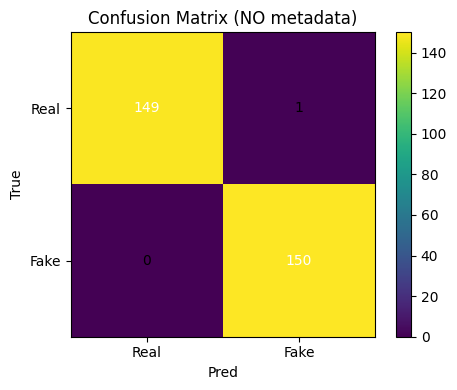

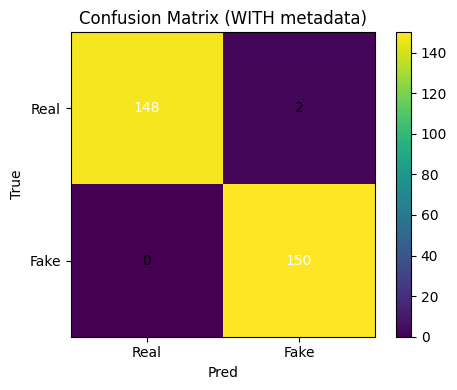


=========== McNemar Test ===========
b (no-meta correct, meta wrong): 1
c (no-meta wrong, meta correct): 0
Net gain (c-b): -1
p-value: 1.0
❌ Not significant (fail to reject H0)



In [16]:
# ============================================================
# ONE-PASS (FAST) + RESUME/CHECKPOINT
# Compare:
#   A) WITHOUT metadata  : video=0.37, audio=0.37, lipsync=0.26, meta=0.00
#   B) WITH metadata     : video=0.35, audio=0.35, lipsync=0.25, meta=0.05
# Then run McNemar test to check if metadata significantly improves.
# ------------------------------------------------------------
# ✅ Computes heavy parts (OpenL3 lipsync etc.) ONCE per video
# ✅ Saves checkpoint every N videos
# ✅ Resume from last checkpoint after session off/crash
# ✅ Outputs:
#    - Acc(no-meta), Acc(with-meta)
#    - Confusion matrices
#    - McNemar (b,c,p-value) + decision
# ============================================================

import os, pickle, gc
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
from statsmodels.stats.contingency_tables import mcnemar


# =========================
# SETTINGS
# =========================
THRESHOLD = 0.5

# IMPORTANT: keep dataset order fixed (load saved data list if you have)
DATA_PATH = "/kaggle/working/mixed_data_fixed.pkl"          # <-- optional but recommended
CKPT_PATH = "/kaggle/working/meta_ablation_ckpt.pkl"        # checkpoint for predictions

SAVE_EVERY = 10
HEARTBEAT_EVERY = 20


# =========================
# OPTIONAL: Fix dataset order
# =========================
def get_or_save_data(build_fn, n_each=150, seed=42, data_path=DATA_PATH):
    """
    Ensures data order is identical across resumes.
    build_fn must return list[(video_path, label)].
    """
    if os.path.exists(data_path):
        with open(data_path, "rb") as f:
            data = pickle.load(f)
        print("✅ Loaded saved data:", len(data))
        return data

    data = build_fn(n_each=n_each, seed=seed)
    if data is None:
        return None

    with open(data_path, "wb") as f:
        pickle.dump(data, f)
    print("✅ Saved data:", len(data))
    return data


# =========================
# ONE-PASS predictor
# =========================
def predict_two_versions_one_pass(video_path):
    """
    Computes base probs ONCE, returns:
      score_no_meta, pred_no_meta, score_with_meta, pred_with_meta
    """
    video_p   = get_video_prob(video_path)
    audio_p   = get_audio_prob(video_path)
    lipsync_p = get_lipsync_prob_avsync(video_path)
    meta_p    = get_metadata_prob_from_video(video_path)

    # A) WITHOUT metadata (exact weights you gave)
    score_no = (
        0.37 * video_p +
        0.37 * audio_p +
        0.26 * lipsync_p +
        0.00 * meta_p
    )
    pred_no = 1 if score_no >= THRESHOLD else 0

    # B) WITH metadata (exact weights you gave)
    score_m = (
        0.35 * video_p +
        0.35 * audio_p +
        0.25 * lipsync_p +
        0.05 * meta_p
    )
    pred_m = 1 if score_m >= THRESHOLD else 0

    return float(score_no), int(pred_no), float(score_m), int(pred_m)


# =========================
# CHECKPOINT SAVE/LOAD
# =========================
def _save_ckpt(path, idx, y_true, p0, p1, s0, s1, failures):
    with open(path, "wb") as f:
        pickle.dump({
            "idx": idx,
            "y_true": y_true,
            "y_pred_no_meta": p0,
            "y_pred_with_meta": p1,
            "y_score_no_meta": s0,
            "y_score_with_meta": s1,
            "failures": failures
        }, f)

def _load_ckpt(path):
    with open(path, "rb") as f:
        return pickle.load(f)


# =========================
# PLOTS
# =========================
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5,4))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1], ["Real", "Fake"])
    plt.yticks([0,1], ["Real", "Fake"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j],
                     ha="center", va="center",
                     color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.tight_layout()
    plt.show()


# =========================
# MAIN: RUN + RESUME
# =========================
def run_meta_ablation_with_resume(data, ckpt_path=CKPT_PATH):
    """
    data = list of (video_path, label)
    label: 0=real, 1=fake
    """
    if data is None or len(data) == 0:
        print("⚠️ Empty data. Stop.")
        return None

    # Resume if exists
    if os.path.exists(ckpt_path):
        ckpt = _load_ckpt(ckpt_path)
        start_idx = int(ckpt.get("idx", 0))

        y_true = ckpt.get("y_true", [])
        y_pred_no = ckpt.get("y_pred_no_meta", [])
        y_pred_m  = ckpt.get("y_pred_with_meta", [])
        y_score_no = ckpt.get("y_score_no_meta", [])
        y_score_m  = ckpt.get("y_score_with_meta", [])
        failures = ckpt.get("failures", [])

        print(f"✅ Resuming from {start_idx}/{len(data)} | fails={len(failures)}")
    else:
        start_idx = 0
        y_true, y_pred_no, y_pred_m, y_score_no, y_score_m, failures = [], [], [], [], [], []
        print("✅ Starting fresh (no checkpoint found)")

    # Warmup (loads models once)
    if start_idx < len(data):
        try:
            vp0, _ = data[start_idx]
            _ = predict_two_versions_one_pass(vp0)
            print("✅ Warmup done")
        except Exception as e:
            print("⚠️ Warmup failed (continuing):", repr(e))

    # Loop
    for i in tqdm(range(start_idx, len(data)), desc="Meta Ablation (one-pass + resume)"):
        vp, label = data[i]
        try:
            s0, p0, s1, p1 = predict_two_versions_one_pass(vp)

            y_true.append(int(label))
            y_pred_no.append(int(p0))
            y_pred_m.append(int(p1))
            y_score_no.append(float(s0))
            y_score_m.append(float(s1))

        except Exception as e:
            failures.append((vp, repr(e)))

        gc.collect()

        if (i + 1) % HEARTBEAT_EVERY == 0:
            print(f"[heartbeat] {i+1}/{len(data)} done | fails={len(failures)}")

        if (i + 1) % SAVE_EVERY == 0:
            _save_ckpt(ckpt_path, i + 1, y_true, y_pred_no, y_pred_m, y_score_no, y_score_m, failures)

    # Final save
    _save_ckpt(ckpt_path, len(data), y_true, y_pred_no, y_pred_m, y_score_no, y_score_m, failures)

    # =========================
    # METRICS
    # =========================
    print("\n================ RESULTS ================")
    print("Planned:", len(data))
    print("Processed:", len(y_true))
    print("Failed:", len(failures))
    print("Checkpoint:", ckpt_path)
    print("========================================\n")

    if len(y_true) == 0:
        print("⚠️ Nothing processed. First 5 failures:")
        for vp, err in failures[:5]:
            print(vp, "->", err)
        return None

    acc_no = accuracy_score(y_true, y_pred_no)
    acc_m  = accuracy_score(y_true, y_pred_m)

    print(f"Accuracy (NO metadata) : {acc_no:.4f}")
    print(f"Accuracy (WITH metadata): {acc_m:.4f}\n")

    print("Classification Report (NO metadata):")
    print(classification_report(y_true, y_pred_no, target_names=["Real(0)", "Fake(1)"]))

    print("Classification Report (WITH metadata):")
    print(classification_report(y_true, y_pred_m, target_names=["Real(0)", "Fake(1)"]))

    cm_no = confusion_matrix(y_true, y_pred_no)
    cm_m  = confusion_matrix(y_true, y_pred_m)

    print("Confusion Matrix (NO metadata):\n", cm_no)
    print("Confusion Matrix (WITH metadata):\n", cm_m)

    plot_confusion_matrix(cm_no, "Confusion Matrix (NO metadata)")
    plot_confusion_matrix(cm_m,  "Confusion Matrix (WITH metadata)")

    # =========================
    # McNemar TEST
    # =========================
    b = 0  # no-meta correct, meta wrong
    c = 0  # no-meta wrong, meta correct

    for yt, p0, p1 in zip(y_true, y_pred_no, y_pred_m):
        no_ok = (p0 == yt)
        me_ok = (p1 == yt)
        if no_ok and not me_ok:
            b += 1
        elif (not no_ok) and me_ok:
            c += 1

    table = [[0, b],
             [c, 0]]

    res = mcnemar(table, exact=False, correction=True)

    print("\n=========== McNemar Test ===========")
    print("b (no-meta correct, meta wrong):", b)
    print("c (no-meta wrong, meta correct):", c)
    print("Net gain (c-b):", c - b)
    print("p-value:", res.pvalue)

    if res.pvalue < 0.05:
        print("✅ Significant improvement with metadata (reject H0)")
    else:
        print("❌ Not significant (fail to reject H0)")
    print("====================================\n")

    if failures:
        print("First 5 failures:")
        for vp, err in failures[:5]:
            print(vp, "->", err)

    return {
        "acc_no_meta": acc_no,
        "acc_with_meta": acc_m,
        "cm_no_meta": cm_no,
        "cm_with_meta": cm_m,
        "b": b,
        "c": c,
        "p_value": res.pvalue,
        "y_true": y_true,
        "y_pred_no_meta": y_pred_no,
        "y_pred_with_meta": y_pred_m,
        "y_score_no_meta": y_score_no,
        "y_score_with_meta": y_score_m,
        "failures": failures,
        "ckpt_path": ckpt_path
    }


# ============================================================
# RUN (put this at the end)
# ============================================================
# 1) Make sure you already have build_mixed_subset() defined in your notebook.

data_fixed = get_or_save_data(build_mixed_subset, n_each=100, seed=42, data_path=DATA_PATH)

results = run_meta_ablation_with_resume(data_fixed, ckpt_path=CKPT_PATH)
